In [ ]:
import os, glob, shutil, zipfile, random, math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files


In [ ]:

print(" upload your dataset .zip file ")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall("/content/trashnet")

print("Dataset at /content/trashnet")


 upload your dataset .zip file 


Saving archive (10).zip to archive (10).zip
Dataset at /content/trashnet


In [ ]:


BASE = "/content/trashnet/dataset-resized"


paths = sum([glob.glob(os.path.join(BASE, c, "*.jpg"))
             for c in os.listdir(BASE) if os.path.isdir(os.path.join(BASE, c))], [])
labels_str = [os.path.basename(os.path.dirname(p)) for p in paths]


In [ ]:
X_tr, X_val, y_tr_str, y_val_str = train_test_split(
    paths, labels_str, test_size=0.2, stratify=labels_str, random_state=42
)


In [ ]:
class_names   = set(labels_str)
class_to_idx  = {c:i for i,c in enumerate(class_names)}
idx_to_class  = {i:c for c,i in class_to_idx.items()}
y_tr  = np.array([class_to_idx[s] for s in y_tr_str],  dtype=np.int32)
y_val = np.array([class_to_idx[s] for s in y_val_str], dtype=np.int32)

In [ ]:
print("Classes:", class_names)
print("Train/Val:", len(X_tr), len(X_val))

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train/Val: 2021 506


In [ ]:
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32

In [ ]:
def decode_and_resize(path, y):
    x = tf.io.decode_image(tf.io.read_file(path), channels=1, expand_animations=False)
    x = tf.image.convert_image_dtype(x, tf.float32)*2.0 - 1.0
    x = tf.image.resize(x, IMAGE_SIZE, antialias=False)
    return x, y

In [ ]:
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
])

In [ ]:
def make_ds(X, y, augment_on=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle: ds = ds.shuffle(len(X), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if augment_on:
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
train_ds = make_ds(X_tr,  y_tr,  augment_on=True,  shuffle=True)
val_ds   = make_ds(X_val, y_val, augment_on=False, shuffle=False)

In [ ]:
# weights[i] = N / (K * count_i)
counts  = np.bincount(y_tr, minlength=len(class_names))
weights = {i: (len(y_tr) / (len(class_names) * counts[i])) for i in range(len(class_names))}
weights


{0: np.float64(1.0460662525879918),
 1: np.float64(0.8399833748960931),
 2: np.float64(1.026930894308943),
 3: np.float64(0.7091228070175438),
 4: np.float64(0.8748917748917749),
 5: np.float64(3.062121212121212)}

In [ ]:
def build_baseline(num_classes):
    inp = layers.Input((*IMAGE_SIZE, 3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x);  x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3, padding='same', activation='relu')(x);  x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(num_classes)(x)
    return keras.Model(inp, out, name="baseline_cnn")

model = build_baseline(len(class_names))
model.compile(optimizer=keras.optimizers.Adam(2),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

cbs = [
    keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=6,
                    class_weight=weights, callbacks=cbs, verbose=1)


Epoch 1/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.1746 - loss: 1.8096 - val_accuracy: 0.1719 - val_loss: 1.7226 - learning_rate: 0.0010
Epoch 2/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.2897 - loss: 1.6799 - val_accuracy: 0.3953 - val_loss: 1.4969 - learning_rate: 0.0010
Epoch 3/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.3641 - loss: 1.5282 - val_accuracy: 0.3518 - val_loss: 1.4840 - learning_rate: 0.0010
Epoch 4/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.3680 - loss: 1.4775 - val_accuracy: 0.3913 - val_loss: 1.3928 - learning_rate: 0.0010
Epoch 5/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.3737 - loss: 1.4347 - val_accuracy: 0.4269 - val_loss: 1.3850 - learning_rate: 0.0010
Epoch 6/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.4179 - loss: 1.4261 - val_accuracy: 0.4170 - val_loss: 1.3910 - learning_rate: 0.0010


              precision    recall  f1-score   support

   cardboard     0.8219    0.7407    0.7792        81
       glass     0.6429    0.1800    0.2812       100
       metal     0.4848    0.5854    0.5304        82
       paper     0.4577    0.5462    0.4981       119
     plastic     0.5288    0.5670    0.5473        97
       trash     0.2167    0.4815    0.2989        27

    accuracy                         0.5119       506
   macro avg     0.5255    0.5168    0.4892       506
weighted avg     0.5578    0.5119    0.5043       506



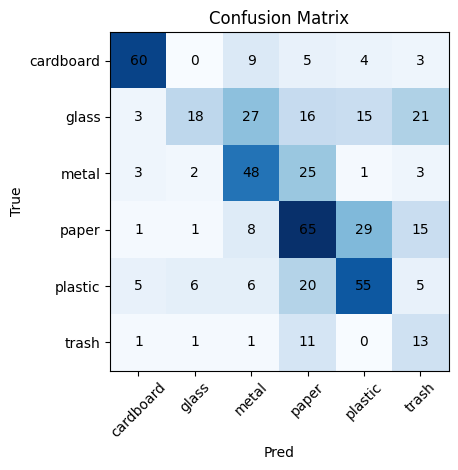

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_prob = model.predict(val_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_val, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45); plt.yticks(range(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout(); plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(class_names)

# callbacks
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=0.5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint("mobilenetv2_best.keras", monitor="val_accuracy", save_best_only=True)
]

#  Phase 1: freeze base, train top ---->
inputs = layers.Input(shape=(*IMAGE_SIZE, 3))

x = layers.Rescaling(2.0, offset=-1.0)(inputs)  # [0,1] -> [-1,1]

base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
base.trainable = False

y = layers.GlobalAveragePooling2D()(base.output)
y = layers.Dropout(0.30)(y)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(y)
tl_model = keras.Model(inputs, outputs, name="mobilenetv2_tl")

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 1: training head only (base frozen)")
history_tl_1 = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=globals().get("weights", None),
    callbacks=cbs,
    verbose=1
)



/tmp/ipython-input-1475669913.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)


Phase 1: training head only (base frozen)
Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.2202 - loss: 1.9847 - val_accuracy: 0.5099 - val_loss: 1.2750 - learning_rate: 3.0000e-04
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4567 - loss: 1.3397 - val_accuracy: 0.6561 - val_loss: 0.9643 - learning_rate: 3.0000e-04
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5775 - loss: 1.0880 - val_accuracy: 0.6996 - val_loss: 0.8343 - learning_rate: 3.0000e-04
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6448 - loss: 0.9675 - val_accuracy: 0.7530 - val_loss: 0.7395 - learning_rate: 3.0000e-04
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6843 - loss: 0.8788 - val_accuracy: 0.7708 - val_loss: 0.6766 - learning_rate: 3.0000e-04
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7082 - loss: 0.8186 - val_accuracy: 0.7846 - val_loss: 0.6524 - learning_rate: 3.0000e-04
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
# ----- Phase 2: unfreeze tail, fine-tune -----
base.trainable = True
# fine-tune last ~40% of layers
freeze_until = int(0.6 * len(base.layers))
for layer in base.layers[freeze_until:]:
    layer.trainable = False

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 2: fine-tuning last layers")
history_tl_2 = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    class_weight=globals().get("weights", None),
    callbacks=cbs,
    verbose=1
)


Phase 2: fine-tuning last layers
Epoch 1/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6703 - loss: 0.9669 - val_accuracy: 0.8043 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 2/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8454 - loss: 0.4210 - val_accuracy: 0.7925 - val_loss: 0.5659 - learning_rate: 1.0000e-04
Epoch 3/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8972 - loss: 0.3012 - val_accuracy: 0.8024 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 4/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9346 - loss: 0.1906 - val_accuracy: 0.8103 - val_loss: 0.5543 - learning_rate: 5.0000e-05
Epoch 5/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9554 - loss: 0.1464 - val_accuracy: 0.8340 - val_loss: 0.5271 - learning_rate: 5.0000e-05
Epoch 6/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9548 - loss: 0.1302 - val_accuracy: 0.8399 - val_loss: 0.5214 - learning_rate: 5.0000e-05
Epoch 7/12
64/64 ━━━━━━━━━━━━━━━━━━━━

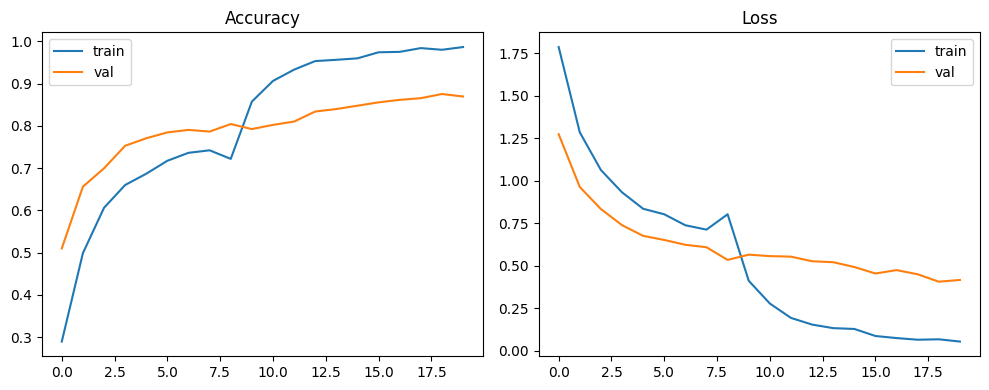

In [ ]:
import matplotlib.pyplot as plt

def merge_hist(*hists):
    acc, val_acc, loss, val_loss = [], [], [], []
    for h in hists:
        if h is None: continue
        acc     += h.history.get('accuracy', [])
        val_acc += h.history.get('val_accuracy', [])
        loss    += h.history.get('loss', [])
        val_loss+= h.history.get('val_loss', [])
    return acc, val_acc, loss, val_loss

h1 = globals().get('history_tl_1')
h2 = globals().get('history_tl_2')
acc, val_acc, loss, val_loss = merge_hist(h1, h2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(acc, label='train'); plt.plot(val_acc, label='val'); plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2); plt.plot(loss, label='train'); plt.plot(val_loss, label='val'); plt.title('Loss'); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def make_eval_ds():
    if 'make_ds' in globals():
        return make_ds(val_paths, y_val, augment=False, shuffle=False)
    return val_ds

eval_ds = make_eval_ds()

y_prob = tl_model.predict(eval_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_val

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Normalized)")
plt.tight_layout(); plt.show()


NameError: name 'val_paths' is not defined